In [1]:
# normal imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns',500)

import warnings
warnings.filterwarnings('ignore')

# all the modeling imports
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance
from sklearn.naive_bayes import GaussianNB

# scoring, feature selection, and gridsearch
from sklearn.metrics import mean_squared_error,accuracy_score, f1_score, roc_auc_score, recall_score, precision_score
from sklearn.model_selection import cross_val_score

from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold

In [2]:
# non aggregates
df_norm = pd.read_csv('data/pbp_data_mvp.csv')
df_norm.drop(columns='Unnamed: 0',inplace=True)

In [3]:
# aggregates (instantiating this up here as it needs columns from df_norm that will be dropped)
df_norm_copy_for_attaching = df_norm[['Date','home_team','away_team','home_outcome','away_outcome','game_number_of_season']]
df_agg = pd.read_csv('data/aggregate_data.csv')
df_agg.drop(columns='Unnamed: 0',inplace=True)

# Base Modeling

### Normal Data (game per game stats)

Each row in this data is the stats from one game. The target is the outcome of the next game.

In [5]:
# dropping the unnecessary cols that wont be used
cols_to_drop = ['forfeit_info','lf_ump_id','rf_ump_id','protest_info',
                'date_game_completed','additional_info','save_pitch_id',
                'game_win_rbi_batter_id','game_in_series','away_catch_interference',
                'home_catch_interference','away_pitch_balks',
                'home_pitch_balks','day_of_week','away_league',
                'away_team_game_number','home_league',
                'home_team_game_number','day_or_night','park_id',
                'attendance','time_of_game','away_line_scores',
                'home_line_scores','year','id','outcome',
               'Date','away_team','home_team']
df_norm.drop(columns=cols_to_drop,inplace=True)
df_norm.drop(df_norm.loc[:,'hb_ump_id':'acquisition_info'],axis=1,inplace=True)

In [6]:
# PASO has some infinite values and those rows are dropped
df_norm.replace([np.inf,-np.inf],np.nan,inplace=True)
df_norm.dropna(inplace=True)

In [7]:
# creating x and y
X_norm = df_norm.drop(columns='target')
y_norm = df_norm.target

`baseline_prediction` will run inputed X and y data on a base model of logistic regression, decision tree, random forest, and XGBoost.

In [8]:
from baseline_model import baseline_prediction

In [9]:
# baseline testing
baseline_prediction(X_norm,y_norm)

Logistic Regression Accuracy
Train=0.536 Test=0.531
Decision Tree Accuracy
Train=0.633 Test=0.508
Random Forest Accuracy
Train=1.0 Test=0.515
XGBoost Accuracy
Train=0.566 Test=0.526


The game by game statistics (only using the last game to predict the next game) performs pretty well. Logistic regression perfoms the best and overfitting is very very low. Decision tree and random forest overfit a ton with very poor results on test. XG boost overfits slightly and performs the same as random forst. Will be doing more testing on logistic regression.

### Aggregate Stats

In [6]:
# changing the name of these becuase we already have the teams win % as this
df_norm_copy_for_attaching.rename(columns={'home_outcome':'home_outcome_nonagg','away_outcome':'away_outcome_nonagg'},inplace=True)
# merging to df
df_agg = df_agg.merge(df_norm_copy_for_attaching,how='left',on=['Date','home_team','away_team'])
# taking out the first 10 games due to them not having enough data
df_agg_cutt_early = df_agg[(df_agg.game_number_of_season > 10)]

In [7]:
# dropping columns no longer needed
cols_to_drop_agg_cutt = ['home_team','away_team','Date','away_outcome_nonagg','game_number_of_season']
df_agg_cutt_early.drop(columns=cols_to_drop_agg_cutt,inplace=True)

In [8]:
# PA/SO can result in infinite value, row dropped
df_agg_cutt_early.replace([np.inf,-np.inf],np.nan,inplace=True)
df_agg_cutt_early.dropna(inplace=True)

In [9]:
# target is the outcome of current game
X_agg_cutt = df_agg_cutt_early.drop(columns='home_outcome_nonagg')
y_agg_cutt = df_agg_cutt_early.home_outcome_nonagg

In [27]:
# baseline testing
baseline_prediction(X_agg_cutt,y_agg_cutt)

Logistic Regression Accuracy
Train=0.564 Test=0.569
Decision Tree Accuracy
Train=0.799 Test=0.543
Random Forest Accuracy
Train=0.991 Test=0.526
XGBoost Accuracy
Train=0.608 Test=0.569


From this we can see that the aggregate data performs better than the normal per game statistics data. The reason for this improvement is each team is not being assesed on only their previous game but all previous games that season. A team is not how well they did last game but how well they have been doing that season. One off game can throw off predictions. Logistic regression and XGBoost are going to be futher improved due to their accuracy in these intial tests.

## Feature Selection

Feature selection can be very useful by reducing the amount of features used in the model while also maintaining/increasing the accuracy score. A filter method of select k-best is going to be used first and then a wrapper method of recursive feature elimination after.

#### Filter Method

In [88]:
# instantiating a feature selector object
feature_selector = SelectKBest(f_classif,50)

# fitting to our data
feature_selector.fit(X_train,y_train)

# features that we keep
selected_filter = X_train.columns[feature_selector.get_support()]

In [89]:
baseline_prediction(X_agg_cutt[selected_filter],y_agg_cutt)

Logistic Regression Accuracy
Train=0.56 Test=0.565
Decision Tree Accuracy
Train=0.78 Test=0.536
Random Forest Accuracy
Train=0.991 Test=0.53
XGBoost Accuracy
Train=0.605 Test=0.565


#### Wrapper Method

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X_agg_cutt,y_agg_cutt,random_state=99)
# we are going to use logistic regression as an estimator as it was the best performer in baseline tests
estimator = LogisticRegression()

feature_selector = RFECV(estimator=estimator, step=1, cv=10,n_jobs=-1)

feature_selector.fit(X_train,y_train)

selected_wrapper = X_train.columns[feature_selector.support_]

print('# of feature pre feature selection: {}'.format(len(X_train.columns)))
print('# of feature post feature selection: {}'.format(len(selected_wrapper)))

# of feature pre feature selection: 76
# of feature post feature selection: 50


In [80]:
baseline_prediction(X_agg_cutt[selected_wrapper],y_agg_cutt)

Logistic Regression Accuracy
Train=0.564 Test=0.568
Decision Tree Accuracy
Train=0.779 Test=0.531
Random Forest Accuracy
Train=0.991 Test=0.531
XGBoost Accuracy
Train=0.605 Test=0.566


The recursive feature elimination produces slightly better results than the filter method. This shows that using 16 less features only decresed prediction accuracy by 0.001 for logistic regression and 0.003 for XGBoost. I am going to continue with the full dataset as computation time is not an issure in this project. I also believe that allowing as much information into the models will aloow for the highest accuracy as much as posssible.

# In Depth Modeling

Now that we have identified the data we are going to use it is time to find the most optimal version of logistic regressiona and XGBoost as they were the best performers. Going to use grid search to find the best parameters for both models.

### What are the aggregated statistics

The way that the aggregated stats are calculated are completelty different than the stats of the normal non-aggregated table. For aggregated stats the varibales are the average of the teams statistics up until that game and not including that current game. This allows us not to have to predict the outcome of the next game (the next game the home team plays) but the outcome of the game in that row. There is no data leakage because the stats from that game have not yet been added to the aggregated stats therefore it is not included in the teams average up until that game.

## Logistic Regression Grid Search

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X_agg_cutt,y_agg_cutt,random_state=80)

In [41]:
# If restarting testing uncomment
# If you want to see how differnt param grids stack up do no reinstantiate
#param_grid_iterations = []

In [71]:
param_grid_lr = { 
    'penalty': ['l2'],
    'C': [1e9,1e8,1e7],
    'max_iter':[600,700,800]
}

grid_lr=GridSearchCV(LogisticRegression(),
                         param_grid_lr, 
                         cv=10, 
                         scoring='accuracy', 
                         verbose=1, 
                         n_jobs=-1)

grid_lr.fit(X_train,y_train)

# Single best score achieved across all params
print(grid_lr.best_score_)

# Dictionary containing the parameters used to generate that score
print(grid_lr.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(grid_lr.best_estimator_)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.1min finished


0.5610928053130169
{'C': 100000000.0, 'max_iter': 800, 'penalty': 'l2'}
LogisticRegression(C=100000000.0, max_iter=800)


In [72]:
# Predict the response for test dataset
y_pred_train = grid_lr.best_estimator_.predict(X_train)
y_pred_test = grid_lr.best_estimator_.predict(X_test)
# getting accuracy scores
train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)
print("Train Accuracy: %f" % (train_acc))
print("Test Accuracy: %f" % (test_acc))
# add param grid and its respective test score to the list
param_grid_iterations.append((grid_lr.best_params_,test_acc))

Train Accuracy: 0.565614
Test Accuracy: 0.559477


In [73]:
# how did those param grids score
for item in param_grid_iterations:
    print(item)

({'C': 10000, 'max_iter': 1000, 'penalty': 'l2'}, 0.5662605200351715)
({'C': 100000.0, 'max_iter': 5000, 'penalty': 'l2'}, 0.5678934807185027)
({'C': 10000000.0, 'max_iter': 5000, 'penalty': 'l2'}, 0.5671398065569652)
({'C': 10000000.0, 'max_iter': 4000, 'penalty': 'l2'}, 0.5671398065569652)
({'C': 10000000.0, 'max_iter': 2000, 'penalty': 'l2'}, 0.5671398065569652)
({'C': 1000000000.0, 'max_iter': 80, 'penalty': 'l2'}, 0.5707825650043964)
({'C': 1000000000.0, 'max_iter': 1000, 'penalty': 'l2'}, 0.5587237784197965)
({'C': 1000000000.0, 'max_iter': 1000, 'penalty': 'l2'}, 0.5587237784197965)
({'C': 100000000.0, 'max_iter': 800, 'penalty': 'l2'}, 0.559477452581334)
({'C': 100000000.0, 'max_iter': 800, 'penalty': 'l2'}, 0.559477452581334)


**Notes from testing**
* L2 after a couple iterations is the best penalty
* higher C values and higher iterations allow for higher scores

After a descent amount of testing I am going to chage the random state to see how that affects scores. The reason for this is because in previous testing I was able to achieve the highest scores through C=1e9, max_iter=80,and an l2 penalty.

**After changing random state**

After chaning random stat what previously gave quite good results not are not that great. The same trends as before are present in that C and max iteartions are trending towards higher values. L2 penalization is always the penalty the grid search chooses.

**Final Notes from logistic regression grid search**

From testing different sets of parameters on this problem, a high regularization score is favorable. L2 is the best performing penalty. Max iterations seems to converge to 80. All of these have the same score but will end with 80 as it has the least iterations but also the same score.

From this we can see the the best logistic regression achieved a score of 57%. This is very good as it is 7% above being completely random which can help inform what team to choose.

#### Obtaining Feature Importances
Logistic regression assings weights to every feature and this is how it makes predictions upon on input. The feature values of that input are then used in a linear combination with the weights to obtain a score. If this score is above a certain threshold it predicts 0 and if below that threshold it predicts 0.

In [24]:
# cannot use above grid search model, defining new model with same params as best model
lr_final = LogisticRegression(penalty='l2',C=1e9,max_iter=80)
lr_final.fit(X_train,y_train);

In [25]:
# pulling out the feature coefficients (weights) along with the respective features
feature_importance = lr_final.coef_[0]
features = X_agg_cutt.columns

In [26]:
# iterating through and sorting by the highest weights (most impacting)
feature_importance_list = []
for feature, importance in zip(features,feature_importance):
    feature_importance_list.append((feature,importance))
feature_importance_list.sort(key=lambda x: np.abs(x[1]),reverse=True)

In [27]:
feature_importance_list[0:20]

[('away_at_bats', -0.04345678209051356),
 ('home_at_bats', -0.04260631266103364),
 ('away_def_putouts', -0.03404399300307917),
 ('home_def_putouts', -0.031812435006491196),
 ('home_total_bases', -0.01812287965758287),
 ('away_total_bases', -0.013503773002808774),
 ('away_def_assists', -0.011995252966007584),
 ('away_so', -0.010932023522150374),
 ('home_hits', -0.01016044205761474),
 ('away_hits', -0.01008158397118806),
 ('home_so', -0.009996888220494748),
 ('away_pitch_earned_runs', -0.009064026657708887),
 ('away_team_earned_runs', -0.009043280913995175),
 ('home_pitch_earned_runs', -0.008213233992382118),
 ('home_team_earned_runs', -0.008202658745812047),
 ('home_left_on_base', -0.007664340582355865),
 ('away_singles', -0.0075775829415152055),
 ('home_def_assists', -0.007176331760961912),
 ('away_PASO', -0.006296537633368216),
 ('away_left_on_base', -0.0062134423405349115)]

## XG Boost Grid Search

Grid Seach of XGBoost will hopefully allow for good predictions as well as easily obtain feature importances.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_agg_cutt,y_agg_cutt,random_state=75)

In [10]:
clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic')
param_dist = {'n_estimators': [300,500],
              'learning_rate': [1,0.1,0.01],
              'max_depth': [5, 7, 10],
              'min_child_weight': [1, 2, 3]
             }
gsearch1 = GridSearchCV(
    estimator = clf_xgb,
    param_grid = param_dist, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    iid=False, 
    cv=5)

In [13]:
gsearch1.fit(X_train,y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 71.8min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 112.6min finished


GridSearchCV(cv=5, estimator=XGBClassifier(), iid=False, n_jobs=-1,
             param_grid={'learning_rate': [1, 0.1, 0.01],
                         'max_depth': [5, 7, 10], 'min_child_weight': [1, 2, 3],
                         'n_estimators': [300, 500]},
             scoring='accuracy', verbose=1)

In [14]:
gsearch1.best_params_

{'learning_rate': 0.01,
 'max_depth': 5,
 'min_child_weight': 2,
 'n_estimators': 300}

In [15]:
gsearch1.best_score_

0.5605894239882687

In [16]:
XG_boost_best_params = []
XG_boost_best_params.append((gsearch1.best_params_,gsearch1.best_score_))

In [17]:
XG_boost_best_params

[({'learning_rate': 0.01,
   'max_depth': 5,
   'min_child_weight': 2,
   'n_estimators': 300},
  0.5605894239882687)]

#### Reinstantiating for plot importance

In [21]:
clf_xgb_final = xgb.XGBClassifier(objective = 'binary:logistic',
                                 learning_rate = 0.01,
                                 max_depth = 5,
                                 min_child_weight = 2,
                                 n_estimators = 300)
clf_xgb_final.fit(X_train,y_train)

XGBClassifier(learning_rate=0.01, max_depth=5, min_child_weight=2,
              n_estimators=300, objective='multi:softprob')

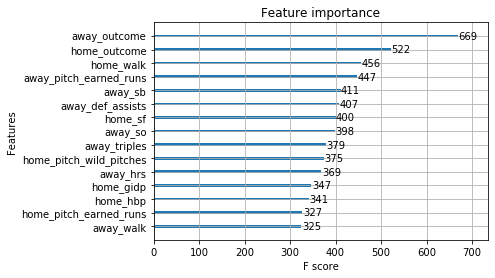

In [27]:
xgb.plot_importance(clf_xgb_final,max_num_features = 15)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

From these feature importances we can see that the record of a team really impacts the outcome of the game. We can also see that the more walks a team is awarded the more likely they are to win the game. Away pitch earned runs means that a more a pitcher gives up runs the more likely we are to win which makes sense. I am assuming that a lot of these say that the less an opposing team perfoms the less they are able to win the game.

## Conclusion

From all this testing we can see that logistic regression reliably performs better than XGBoost.  